In [56]:
# just for easier debugging
from typing import *
# phase 1 imports
import numpy as np
import pandas as pd
import scipy.stats as stats
from distributed.utils_test import throws
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
# phase 2 imports
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif, mutual_info_classif, RFE
# phase 3 imports
from collections import Counter
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from time import time

In [3]:
# functions to redo phase 1
def get_outliers(column: pd.Series):
    lower_quartile = column.quantile(0.25)
    upper_quartile = column.quantile(0.75)
    iqr = upper_quartile - lower_quartile
    return column[(column < lower_quartile - 1.5*iqr) | (column > upper_quartile + 1.5*iqr)]
def iterative_reformat(processes_ptr: pd.DataFrame, connections_ptr: pd.DataFrame) -> pd.DataFrame:
    connections_ptr['ts'] = pd.to_datetime(connections_ptr['ts'])
    processes_ptr['ts'] = pd.to_datetime(processes_ptr['ts'])
    merged = processes_ptr.merge(connections_ptr, on=['ts', 'imei', 'mwra'], how='inner')
    merged['mwra'] = merged['mwra'].astype('int64')
    merged.drop(columns=['ts', 'imei'], inplace=True)
    to_drop = []
    # handle null values and outliers
    for column in merged.columns:
        # if more than 5% are NaN values or more than 5% are outliers, we don't use that column
        column_outliers = get_outliers(merged[column])
        if ((merged[column].isna().sum()/merged.shape[0] > 0.05) or 
            (column_outliers.shape[0] / merged.shape[0] > 0.05)):
            to_drop.append(column)
            continue
        # if there are some null values, we replace the data that's neutral in respect to mwra
        if merged[column].isnull().any():
            # we get means of the distributions for rows with present and non-present malware related activity
            means_per_mwra = merged.groupby('mwra')[column].mean()
            # we average those means, meaning the manufactured value won't be likely to affect predicted mwra 
            imputed_value = means_per_mwra.mean()
            merged[column].fillna(imputed_value, inplace=True)
        #  if there are any outliers, we replace them with the edge values. If we clipped all outliers, we would clutter way too much data together, so we clip only the most extreme ones
        if column_outliers.shape[0]:
            iqr = stats.iqr(merged[column])
            lower_limit = merged[column].quantile(0.25)  - 2.5 * iqr
            upper_limit = merged[column].quantile(0.75)  + 2.5 * iqr
            merged[column] = merged[column].clip(lower=lower_limit, upper=upper_limit)
    return merged.drop(columns=to_drop)
# functions to redo phase 2

In [84]:
# getting the data from previous phases
connections, processes, = pd.read_csv('data/connections.csv', sep='\t', keep_default_na=False, na_values=''), pd.read_csv('data/processes.csv', sep='\t', keep_default_na=False, na_values=''),
combined_table = iterative_reformat(processes, connections)
X = combined_table.drop(columns=['mwra'])
y = combined_table['mwra']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Phase 3: Machine Learning

# Phase 3-1: Implementing ID3 Classifier  

## 3-1A: Implementation

As we are dealing with continuous data, we will be using a different version of the ID3 algorithm opposed to the one shown in the lecture.  
Our implementation was inspired by the following implementation: https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/

In [90]:
def calculate_entropy(data):
    counts = np.bincount(data)
    probabilities = counts / len(data)
    return entropy(probabilities, base=2) # base=2 to use log2


class ID3classifier:
    class Node:
        def __init__(self, feature=None, result=None, value=None, left_child=None, right_child=None):
            self.feature: np.array = feature # column index of criteria being tested
            self.result: Union[0, 1] = result
            self.split_point: int = value
            self.left_child: Optional['ID3classifier.Node'] = left_child
            self.right_child: Optional['ID3classifier.Node'] = right_child
            
    def __init__(self, max_depth=None, min_samples_split=2, threshold=0):
        self.root: Optional['ID3classifier.Node'] = None
        self.max_depth: int = max_depth
        self.min_samples_split: int = min_samples_split
        self.threshold: float = threshold
        
    def fit(self, data_samples: np.array, target_values: list[int], do_best_split_point: bool = False):
        if do_best_split_point:
            data_samples = self._devary_df(data_samples, 15)
            self.root = self._long_build(data_samples, target_values)
        else:
            self.root = self._build(data_samples, target_values)
        
    def _build(self, X, y, depth=0):
        # going through halt conditions
        if (len(set(y)) == 1 or 
                (self.max_depth is not None and depth >= self.max_depth) or
                (y.shape[0] < self.min_samples_split)):
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            split_point = np.median(X[:, feature])
            left_indices = X[:, feature] < split_point
            right_indices = X[:, feature] >= split_point
            left_X, left_y = X[left_indices], y[left_indices]
            right_X, right_y = X[right_indices], y[right_indices]
            left_entropy = calculate_entropy(left_y)
            right_entropy = calculate_entropy(right_y)
            left_p = len(left_y) / len(y)
            right_p = 1 - left_p
            entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
            
            if entropy_gain > best_entropy_gain:
                best_entropy_gain = entropy_gain
                best_feature = feature
                best_split_point = split_point
                best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                
        if best_entropy_gain > self.threshold:
            left_child = self._build(best_left_X, best_left_y, depth + 1)
            right_child = self._build(best_right_X, best_right_y, depth + 1)
            return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])
    
    def _long_build(self, X, y, depth=0):
        if (len(set(y)) == 1 or 
                (self.max_depth is not None and depth >= self.max_depth) or
                (y.shape[0] < self.min_samples_split)):
            return self.Node(result=Counter(y).most_common(1)[0][0])
        
        best_entropy_gain = 0
        best_feature = None
        best_split_point = None
        features_length = X.shape[1]
        current_entropy = calculate_entropy(y)
        best_left_X, best_left_y, best_right_X, best_right_y = None, None, None, None
        for feature in range(features_length):
            #JANKA changed - we are looking for the best split point (= split with highest entropy gain)
            feature_values = set(X[:, feature])
            for split_point in feature_values:
                left_indices = X[:, feature] < split_point
                right_indices = X[:, feature] >= split_point
                left_X, left_y = X[left_indices], y[left_indices]
                right_X, right_y = X[right_indices], y[right_indices]
                left_entropy = calculate_entropy(left_y)
                right_entropy = calculate_entropy(right_y)
                left_p = len(left_y) / len(y)
                right_p = 1 - left_p
                entropy_gain = current_entropy - (left_p * left_entropy + right_p * right_entropy)
                if entropy_gain > best_entropy_gain:
                    best_entropy_gain = entropy_gain
                    best_feature = feature
                    best_split_point = split_point
                    best_left_X, best_left_y, best_right_X, best_right_y = left_X, left_y, right_X, right_y
                    
            if best_entropy_gain > self.threshold:
                left_child = self._build(best_left_X, best_left_y, depth + 1)
                right_child = self._build(best_right_X, best_right_y, depth + 1)
                return self.Node(feature=best_feature, value=best_split_point ,left_child=left_child, right_child=right_child)
        
        # if no split found, return the most common label by default
        return self.Node(result=Counter(y).most_common(1)[0][0])
                    
    def _devary_df(self, df: np.array, strength: int = 2):
        df //= strength
        # df *= strength
        return df
        
    def predict(self, item):
        if self.root is None:
            raise ValueError('The model has not been trained yet.')
            
        # the depth has to be at least 2, including root, because it's a condition in the assignment 
        if self.root.left_child is None and self.root.right_child is None:
            return None
        return self._predict(self.root, item)
        
    def _predict(self, node, item):
        if node.result is not None:
            return node.result
        if item[node.feature] < node.split_point:
            return self._predict(node.left_child, item)
        return self._predict(node.right_child, item)
        

## 3-1B & 3-1C: Testing using accuracy, precision and recall and testing overfitting

In [19]:
def show_metrics(predicted_train, predicted_test, real_train, real_test):
    test_precision_scores   = precision_score(real_test, predicted_test, average=None)
    test_precision_true     = test_precision_scores[0]
    test_precision_false    = test_precision_scores[1]
    test_precision_weighted = precision_score(real_test, predicted_test, average='weighted')
    test_recall_scores      = recall_score(real_test, predicted_test, average=None)
    test_recall_false       = test_recall_scores[0]
    test_recall_true        = test_recall_scores[1]
    test_recall_weighted    = recall_score(real_test, predicted_test, average='weighted')
    test_accuracy           = accuracy_score(real_test, predicted_test)
    train_precision_scores  = precision_score(real_train, predicted_train, average=None)
    train_precision_true    = train_precision_scores[0]
    train_precision_false   = train_precision_scores[1]
    train_precision_weighted= precision_score(real_train, predicted_train, average='weighted')
    train_recall_scores     = recall_score(real_train, predicted_train, average=None)
    train_recall_false      = train_recall_scores[0]
    train_recall_true       = train_recall_scores[1]
    train_recall_weighted   = recall_score(real_train, predicted_train, average='weighted')
    train_accuracy          = accuracy_score(real_train, predicted_train)

    df = pd.DataFrame({
        'Train': [train_precision_true, train_precision_false, train_precision_weighted, train_recall_true, train_recall_false, train_recall_weighted, train_accuracy],
        'Test': [test_precision_true, test_precision_false, test_precision_weighted, test_recall_true, test_recall_false, test_recall_weighted, test_accuracy]
    }, index=['Precision True', 'Precision False', 'Precision Weighted', 'Recall True', 'Recall False', 'Recall Weighted', 'Accuracy'])
    return df

Before we start testing, we need to check if our testing data is balanced, so we know which metrics to prioritize and whether we need to use oversampling or undersampling.

In [20]:
positives_y_train = y_train[y_train == 1].shape[0]
positive_ratio_y_train = round(positives_y_train / y_train.shape[0], 2)
positives_y_test = y_test[y_test == 1].shape[0]
positive_ratio_y_test = round(positives_y_test / y_test.shape[0], 2)
print(f'Positive percentage in training data: {positive_ratio_y_train*100}%.\nPositive percentage in testing data: {positive_ratio_y_test*100}%.')

Positive percentage in training data: 63.0%.
Positive percentage in testing data: 62.0%.


We found small imbalance, but it's not significant enough to warrant oversampling or under-sampling as oversampling would provide synthetic data, which may not represent real patterns and under-sampling would remove too much data.

#### First step of testing, we test the classifier without changing any of the hyperparameters. That means we will not limit the depth of the tree, the minimum samples required to split a node or change the threshold for entropy gain.

In [71]:
unmodified_id3 = ID3classifier()
unmodified_id3.fit(X_train.values, y_train.values)

In [73]:
# getting predicted values for testing data, but also training data to check for overfitting
y_pred = np.array([unmodified_id3.predict(item) for item in X_test.values])
y_pred_train = np.array([unmodified_id3.predict(item) for item in X_train.values])

Since using precision and recall with average='micro' is the same as accuracy, we will use average=None to get the scores for both classes.

In [74]:
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,1.0,0.784535
Precision False,1.0,0.864153
Precision Weighted,1.0,0.834080
Recall True,1.0,0.870901
Recall False,1.0,0.774443
Recall Weighted,1.0,0.834467
Accuracy,1.0,0.834467


Initial thing we can see is that the training data is overfitting, as all the metrics are 100%.  
In testing data, the metrics are all in the 80% range which is not bad, but it's not great as always predicting true would give us 63% accuracy.
We can confirm the imbalance by the fact that precision for true is lower than recall for true implying a lot more false positives than false negatives.
But the imbalance isn't as bad, as the weighted recall and precision are both really close to the accuracy.

We can also try a method that tries to find the best split point for each feature, which should increase the performance.

In [81]:
best_split_id3 = ID3classifier()
best_split_id3.fit(X_train.values, y_train.values, do_best_split_point=True)
y_pred = np.array([best_split_id3.predict(item) for item in X_test.values])
y_pred_train = np.array([best_split_id3.predict(item) for item in X_train.values])
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.978431,0.764159
Precision False,0.990329,0.862395
Precision Weighted,0.985928,0.825290
Recall True,0.987273,0.854763
Recall False,0.983574,0.775300
Recall Weighted,0.985905,0.824749
Accuracy,0.985905,0.824749


Using the best split point only lowered the performance as we needed to bin the data to get it done in a reasonable time (What takes 1 minute with taking the mean would take 8 days with the best split point method).

We can try to limit the depth of the tree to see if it will help with overfitting.

In [67]:
bounded_id3 = ID3classifier(max_depth=5)
bounded_id3.fit(X_train.values, y_train.values)

In [68]:
y_pred = np.array([bounded_id3.predict(item) for item in X_test.values])
y_pred_train = np.array([bounded_id3.predict(item) for item in X_train.values])
show_metrics(y_pred_train, y_pred, y_train, y_test)

,Train,Test
Precision True,0.897140,0.905920
Precision False,0.865596,0.855675
Precision Weighted,0.877263,0.874653
Recall True,0.949608,0.953670
Recall False,0.748795,0.734991
Recall Weighted,0.875334,0.871072
Accuracy,0.875334,0.871072


We can see that despite way lower accuracy in the training dataset, on the testing dataset it has improved and even performed better than on the training dataset in some metrics. 

### Observations
- When we ignore overfitting, the ID3 algorithm has 83% accuracy compared to 63% accuracy if we always assume mwra is true.
- The base ID3 algorithm is prone to overfitting.
- Limiting the maximum depth greatly helps with overfitting. 

### Tuning the hyperparameters
In a later step, we will test multiple hyperparameters of a different function more in depth, but for now we can test just a few.

In [63]:
def test_id3_hyperparameters(max_depth=None, min_samples_split=2, threshold=0):
    modified_id3 = ID3classifier(max_depth=max_depth, min_samples_split=min_samples_split, threshold=threshold)
    modified_id3.fit(X_train.values, y_train.values)
    y_pred = np.array([modified_id3.predict(item) for item in X_test.values])
    y_pred_train = np.array([modified_id3.predict(item) for item in X_train.values])
    return show_metrics(y_pred_train, y_pred, y_train, y_test)

In [69]:
test_id3_hyperparameters(max_depth=10)

,Train,Test
Precision True,0.910945,0.858803
Precision False,0.931165,0.895833
Precision Weighted,0.923686,0.881846
Recall True,0.949479,0.917751
Recall False,0.880420,0.824185
Recall Weighted,0.923937,0.882410
Accuracy,0.923937,0.882410


In [45]:
test_id3_hyperparameters(max_depth=10, min_samples_split=10)

,Train,Test
Precision True,0.906722,0.866667
Precision False,0.924727,0.891064
Precision Weighted,0.918067,0.881849
Recall True,0.947551,0.923998
Recall False,0.868594,0.813894
Recall Weighted,0.918348,0.882410
Accuracy,0.918348,0.882410


In [46]:
test_id3_hyperparameters(max_depth=10, min_samples_split=50)

,Train,Test
Precision True,0.900811,0.903349
Precision False,0.903325,0.891283
Precision Weighted,0.902395,0.895841
Recall True,0.946523,0.947423
Recall False,0.827420,0.809605
Recall Weighted,0.902471,0.895368
Accuracy,0.902471,0.895368


In [50]:
test_id3_hyperparameters(max_depth=10, min_samples_split=200)

,Train,Test
Precision True,0.895088,0.908000
Precision False,0.886665,0.876378
Precision Weighted,0.889780,0.888322
Recall True,0.945366,0.952108
Recall False,0.794131,0.778731
Recall Weighted,0.889429,0.886621
Accuracy,0.889429,0.886621


In [53]:
test_id3_hyperparameters(max_depth=10, min_samples_split=50, threshold=0.03)

,Train,Test
Precision True,0.867529,0.880597
Precision False,0.877516,0.865034
Precision Weighted,0.873822,0.870912
Recall True,0.930197,0.937533
Recall False,0.778800,0.759005
Recall Weighted,0.874200,0.870100
Accuracy,0.874200,0.870100


In [62]:
test_id3_hyperparameters(threshold=0.01)

,Train,Test
Precision True,0.945123,0.869844
Precision False,0.941683,0.891283
Precision Weighted,0.942956,0.883185
Recall True,0.969405,0.926080
Recall False,0.897722,0.813894
Recall Weighted,0.942892,0.883706
Accuracy,0.942892,0.883706


In [61]:
time_before = time()
test_id3_hyperparameters()
time_middle = time()
test_id3_hyperparameters(threshold=0.02)
time_after = time()
print(f"Time without threshold: {time_middle - time_before}, time with threshold: {time_after - time_middle}")

Time without threshold: 29.188769578933716, time with threshold: 2.0605218410491943


#### Finding at which depth the algorithm starts to overfit

In [64]:
accuracies_train = []
accuracies_test = []
for i in range(2, 20):
    modified_id3 = ID3classifier(max_depth=i)
    modified_id3.fit(X_train.values, y_train.values)
    y_pred = np.array([modified_id3.predict(item) for item in X_test.values])
    y_pred_train = np.array([modified_id3.predict(item) for item in X_train.values])
    accuracies_train.append(accuracy_score(y_train, y_pred_train))
    accuracies_test.append(accuracy_score(y_test, y_pred))

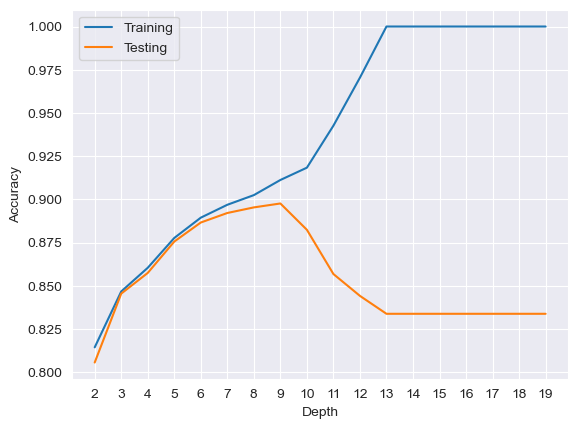

In [96]:
plt.plot(range(2, 20), accuracies_train, label='Training')
plt.plot(range(2, 20), accuracies_test, label='Testing')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(2, 20, step=1))
plt.legend()
plt.show()

### Results
- depth:  
We learned that lowering the depth of the tree is beneficial to speed up the function and prevent overfitting and it can even improve the performance on the testing dataset, but only to a certain point, after which we start to get problems with overfitting. To be precise, the best depth for this dataset is 9 before data starts overfitting.
- min_samples_split:  
Same as with depth, raising min_sample_split helped in all areas, but also only to a certain point.
- threshold:  
Raising the threshold had same effects as the previous ones. The main benefit of tweaking this hyperparameter in combination 
- accuracy:  
In the best configuration out of the few we tested, highest accuracy we achieved on the testing dataset was 89.5%.